In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm #library to make a progress bar when doing long for loops
from scipy.optimize import curve_fit #for forcing curve fit
import time #for testing efficiency of code

import warnings
warnings.filterwarnings('ignore') #suppressed normal warnings (disable this if something stops working)

In [15]:
#Import data for processing

filename = "./28-11-2020/SMC_randpoint_1.xlsx"
#filename = "./03-09-2020/FLPID_4rose_1.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])

while data.iloc[0]['rb1z']==0.0:
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        


83.4726975630916

In [16]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

#rotate desired position to be in line with robot
#xd_rot =data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
#yd_rot =data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
xd_rot = data['xd']
yd_rot = data['yd']


xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))


#set robot initial position to the origin
#x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
#y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [17]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
pdata.insert(2, "y_r", yr_rot,True)
pdata.insert(3, "theta_r", theta_r,True)

pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)

pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
pdata.insert(8,'e_y', pdata['y_r']-pdata['y_d'])
pdata.insert(9,'e_theta', pdata['theta_r']-pdata['theta_d'])

pdata.insert(10,'e_x_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(11,'e_y_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(12,'e_theta_nt',np.zeros(len(pdata['x_r'])))

#for i in range (1000,len(pdata['theta_r'])): #use to drop the last x amount of data
#    pdata = pdata.drop(i)

#for i in range(0, 200):
#    pdata = pdata.drop(i)

In [5]:
Chopnum=100
Min_index = 0

for i in tqdm(range(Chopnum, len(pdata['x_r'])-Chopnum-1)): #Minimize total RMSE
    #print(i)
    temp = np.sqrt(np.square(pdata.at[i,'x_r']-pdata[i-Chopnum:i+Chopnum]['x_d']) #Using ABS is about twice as fast, but gives a different answer
               + np.square(pdata.at[i,'y_r']-pdata[i-Chopnum:i+Chopnum]['y_d']) 
               + np.square(pdata.at[i,'theta_r']-pdata[i-Chopnum:i+Chopnum]['theta_d']))
    Min_index= np.argmin(temp)+i-Chopnum
    
    pdata.iat[i,10] = (pdata.iat[i,1]-pdata.iat[Min_index,4])
    pdata.iat[i,11] = (pdata.iat[i,2]-pdata.iat[Min_index,5])
    pdata.iat[i,12] = (pdata.iat[i,3]-pdata.iat[Min_index,6])

    
pdata.drop(index=np.linspace(0,Chopnum,num=Chopnum+1,dtype=int),inplace=True)
pdata.drop(index=np.linspace(len(pdata['theta_r'])-Chopnum,len(pdata['theta_r']),num=Chopnum+1,dtype=int),inplace=True)
pdata.reset_index(inplace=True, drop=True)

100%|█████████████████████████████████████████████████████████████████████████████| 7848/7848 [00:17<00:00, 460.77it/s]


In [144]:
#Do additional trimming here, don't forget to fix the indexing after!!!!
for i in range(0, 200):
    pdata = pdata.drop(i)
pdata.index-=200

In [145]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

RMSE_x_nt = np.sqrt(sum(pdata['e_x_nt']**2)/len(pdata['e_x']))
RMSE_y_nt = np.sqrt(sum(pdata['e_y_nt']**2)/len(pdata['e_y']))
RMSE_theta_nt = np.sqrt(sum(pdata['e_theta_nt']**2)/len(pdata['e_theta']))

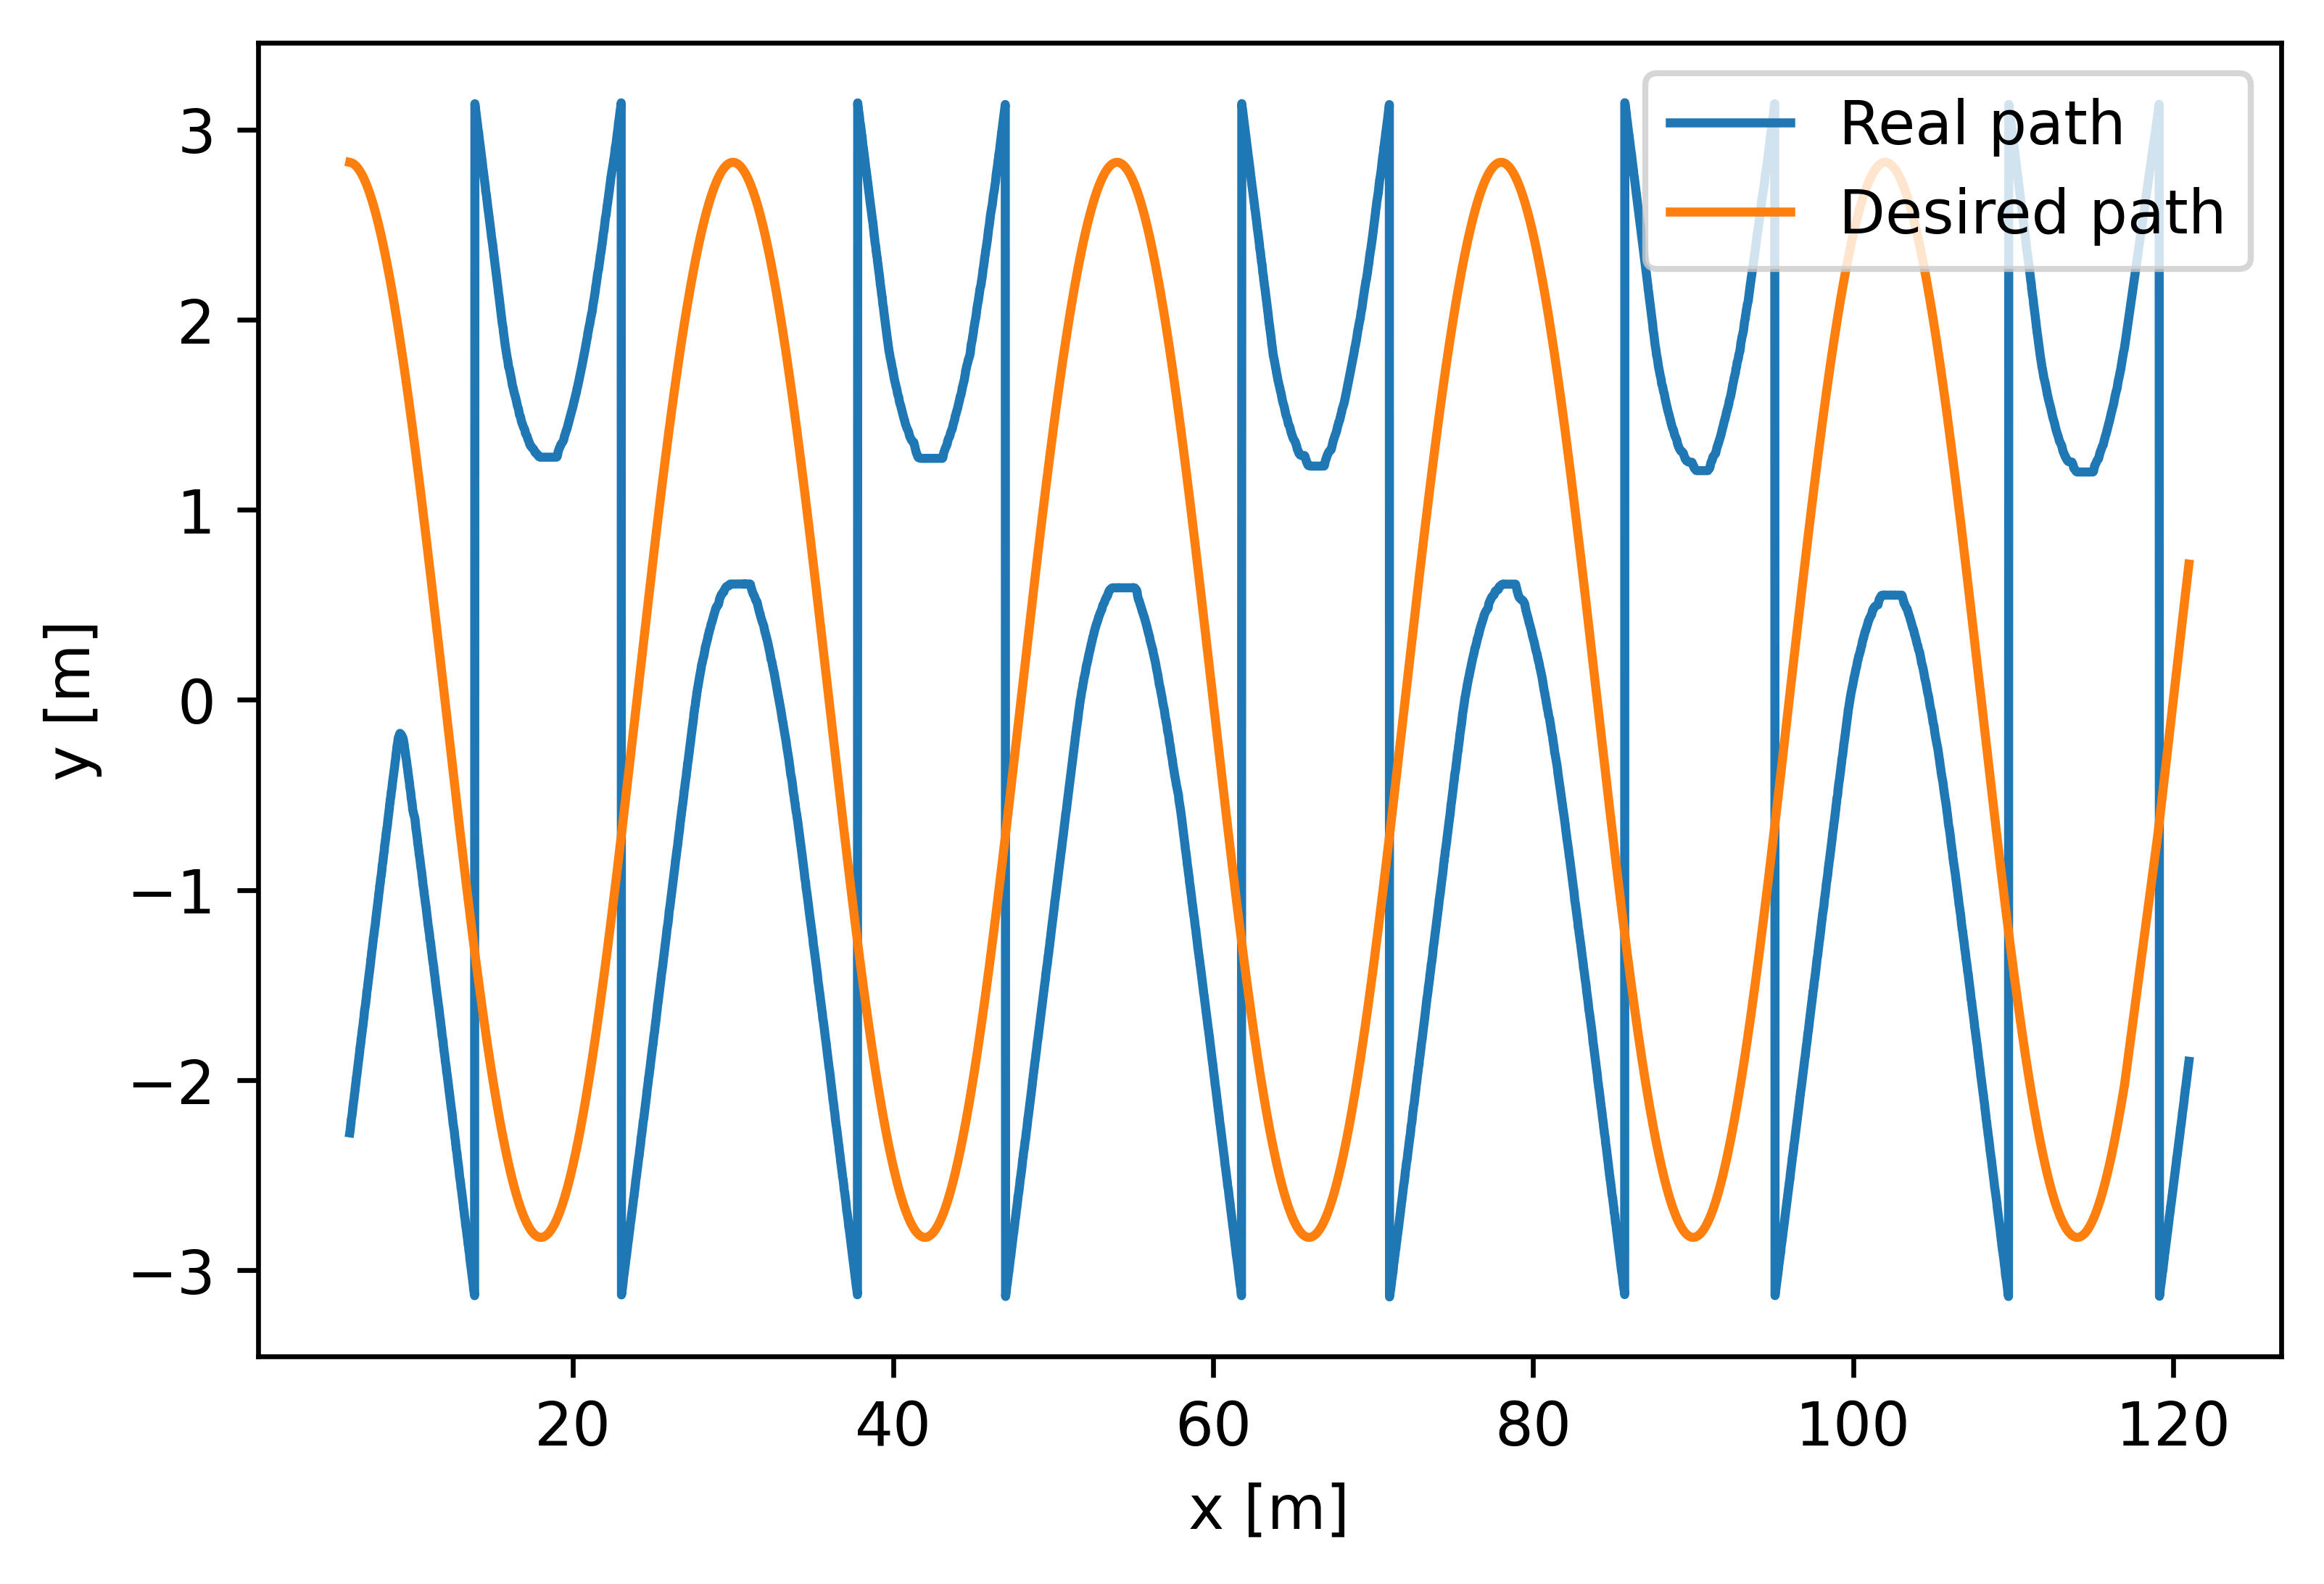

In [146]:
fig = plt.figure(dpi=600)
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
#ax.plot(pdata['x_r'],pdata['y_r'],pd.concat([pd.Series([0]), pdata['x_d']]),pd.concat([pd.Series([0]), pdata['y_d']]))
ax.plot(pdata['globaltime'],(pdata['theta_r'] + np.pi) % (2 * np.pi) - np.pi)
ax.plot(pdata['globaltime'],(pdata['theta_d'] + np.pi) % (2 * np.pi) - np.pi)
ax.legend(['Real path', 'Desired path'])
#ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
#print(pdata.iloc[0]['x_d'])
#print(pdata.iloc[0]['y_d'])
#print(np.arctan2(y_mid[0],x_mid[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
#plt.scatter(0,0)
#plt.text(0,-0.1, 'Start', fontsize=10) #put the start point in
plt.savefig('SMCrand.pdf', format='pdf', bbox_inches='tight')
plt.show()

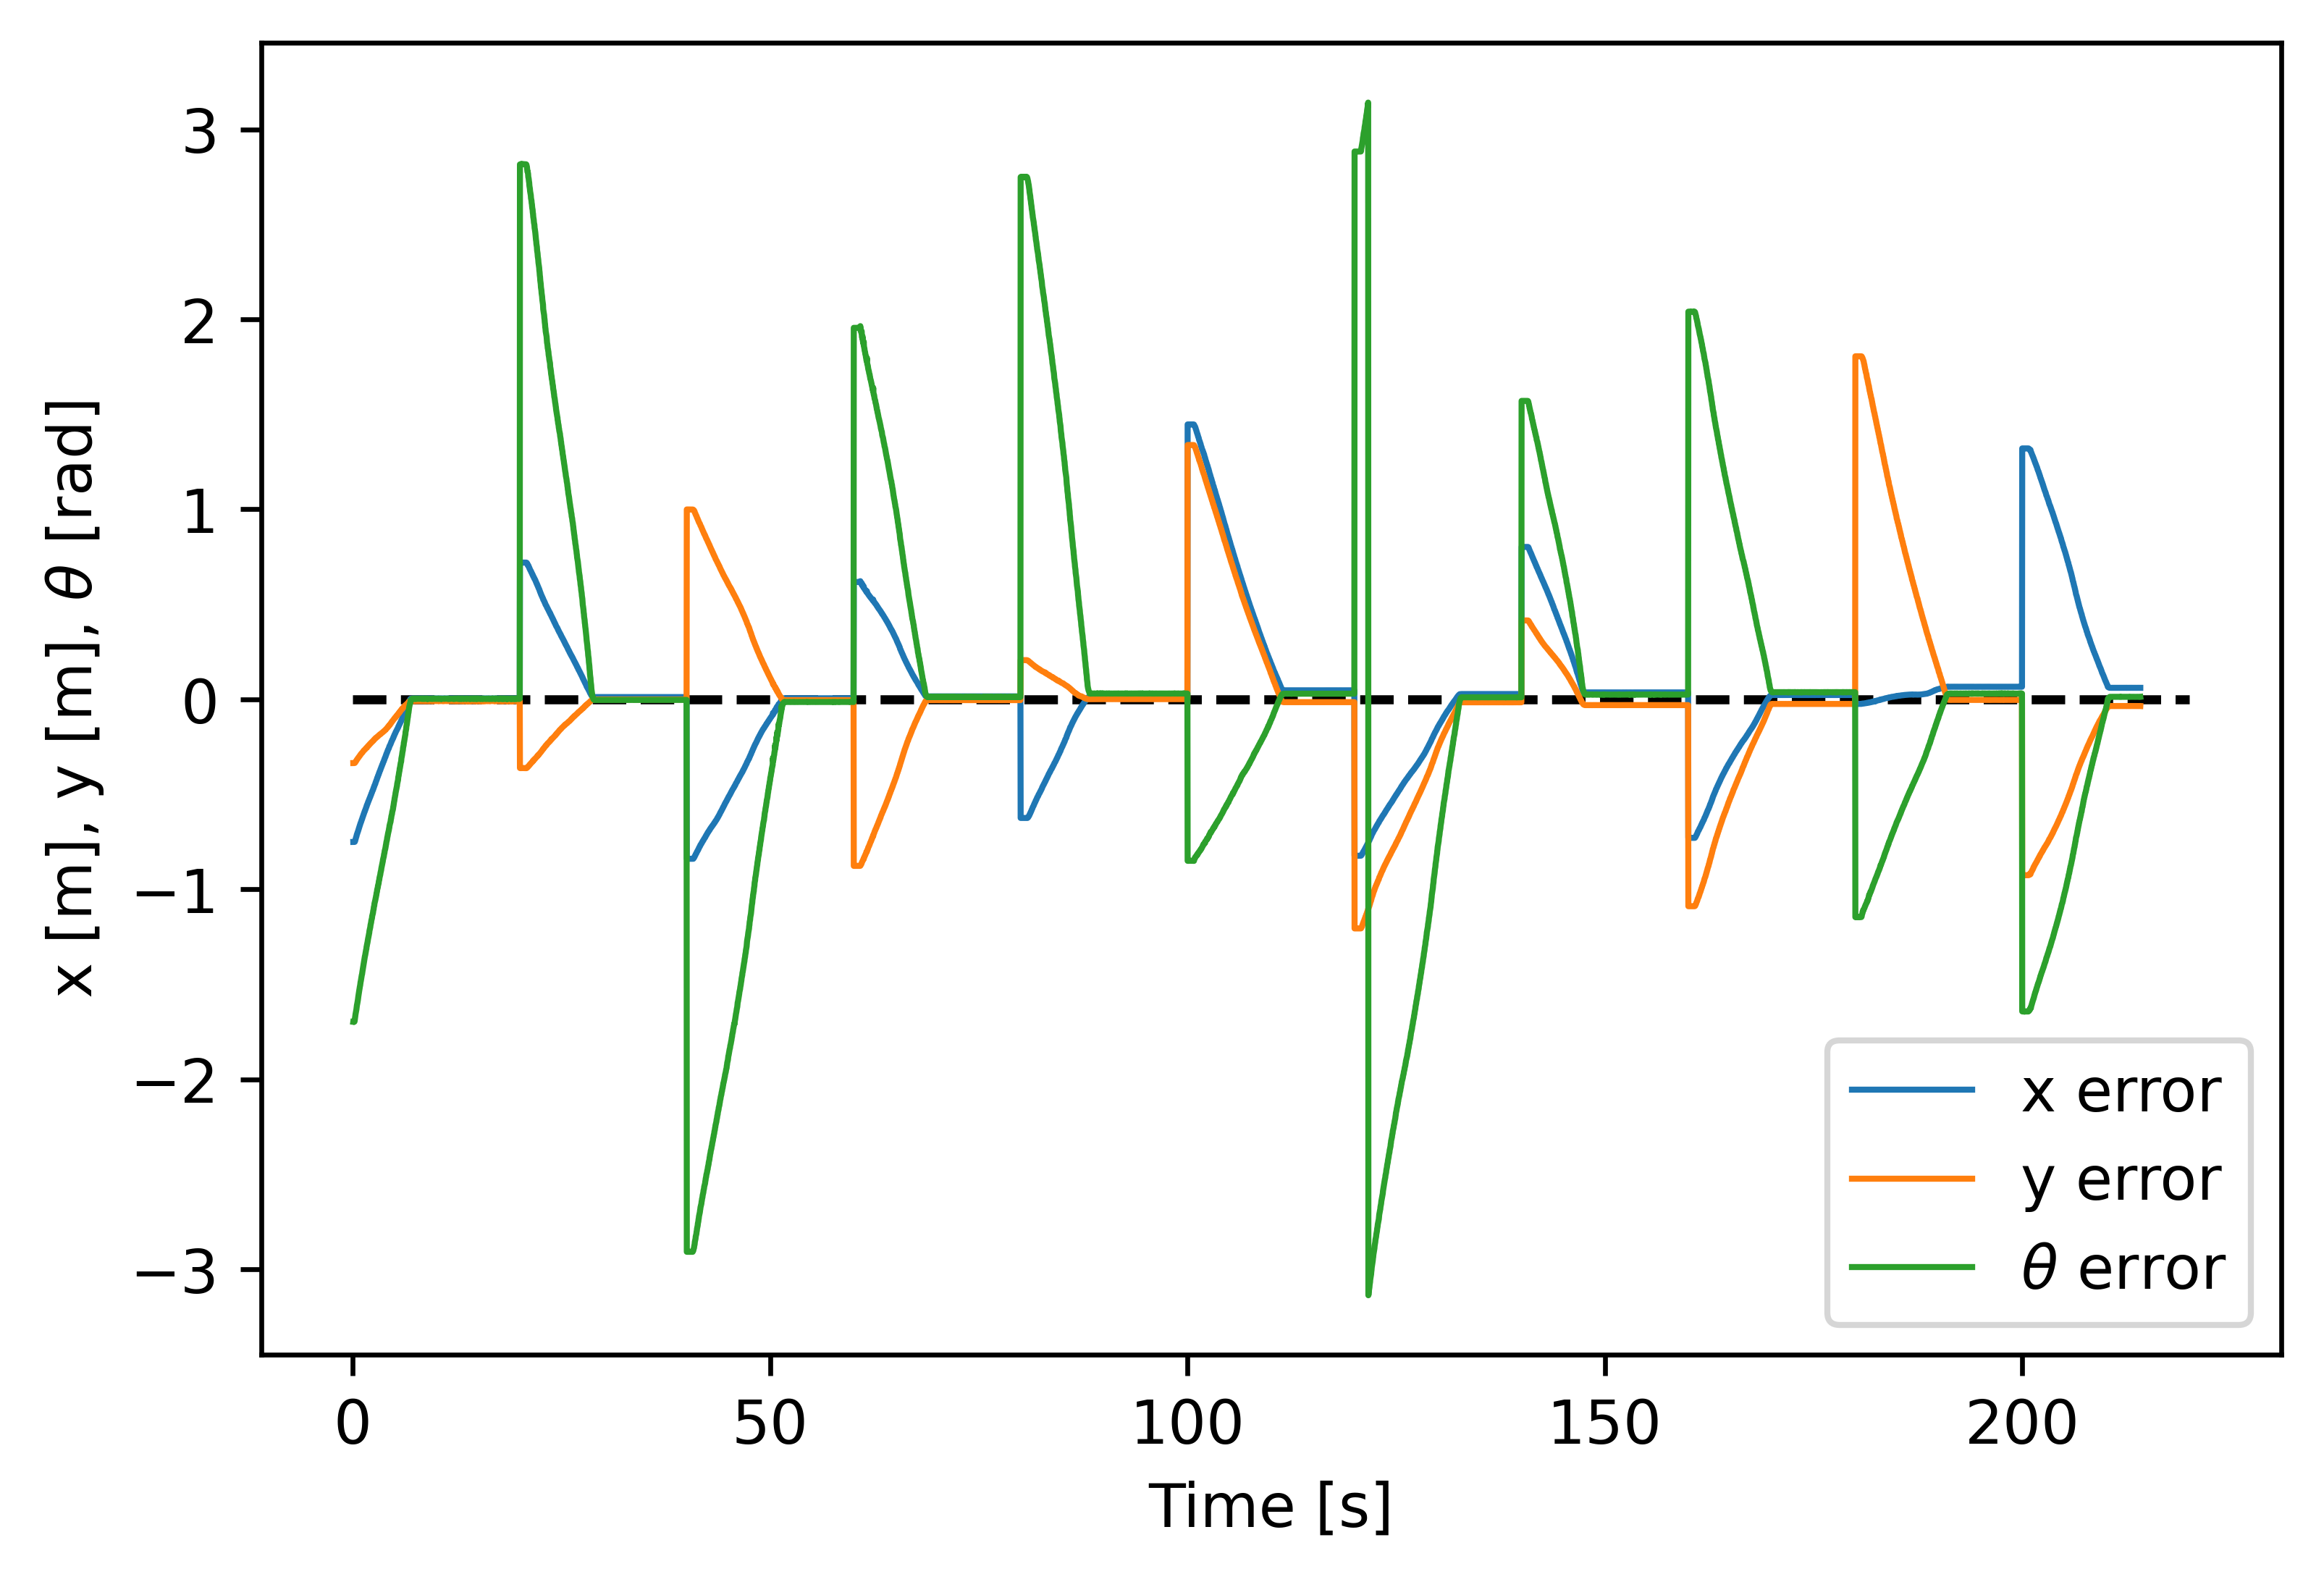

In [18]:
fig = plt.figure(dpi=600)
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
ax.plot(pdata['globaltime'],pdata['x_r']-pdata['x_d'],linewidth=1)
ax.plot(pdata['globaltime'],pdata['y_r']-pdata['y_d'],linewidth=1)
ax.plot(pdata['globaltime'],(pdata['theta_r']-pdata['theta_d'] + np.pi) % (2 * np.pi) - np.pi,linewidth=1)
plt.hlines(0, 0, 220, linestyle="dashed")
plt.xlabel('Time [s]')
plt.ylabel(r'x [m], y [m], $\theta$ [rad]')
ax.legend(['x error', 'y error', r'$\theta$ error'])
plt.savefig('SMCrand.pdf', format='pdf', bbox_inches='tight')

In [132]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

print(RMSE_x_nt)
print(RMSE_y_nt)
print(RMSE_theta_nt)

0.0021432353886262755
0.0038785445631958596
4.108695621568129
0.002087660116382546
0.0037604740422847865
3.341949628927031


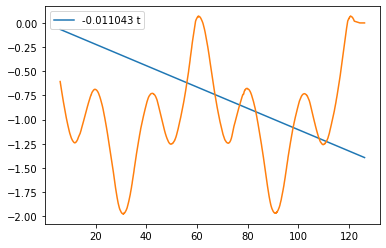

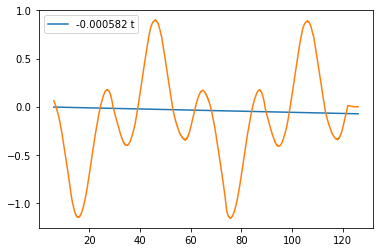

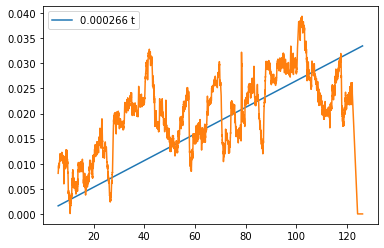

'\n\nm_x,b_x = np.polyfit(pdata[\'globaltime\'], pdata[\'e_x_nt\'], 1) # Come up with linear fits for drift (b!=0)\nm_y,b_y = np.polyfit(pdata[\'globaltime\'], pdata[\'e_y_nt\'], 1)\nm_theta,b_theta = np.polyfit(pdata[\'globaltime\'], pdata[\'e_theta_nt\'], 1)\n\nplt.plot(pdata[\'globaltime\'],m_x*pdata[\'globaltime\']+b_x,label=("%f t %f" % (m_x,b_x)))\nplt.plot(pdata[\'globaltime\'],pdata[\'e_x_nt\'])\nplt.legend()\nplt.show()\n\nplt.plot(pdata[\'globaltime\'],m_y*pdata[\'globaltime\']+b_y,label=("%f t %f" % (m_y,b_y)))\nplt.plot(pdata[\'globaltime\'],pdata[\'e_y_nt\'])\nplt.legend()\nplt.show()\n\nplt.plot(pdata[\'globaltime\'],m_theta*pdata[\'globaltime\']+b_theta,label=("%f t %f" % (m_theta,b_theta)))\nplt.plot(pdata[\'globaltime\'],pdata[\'e_theta_nt\'])\nplt.legend()\nplt.show()'

In [10]:
def fit_func(x, a): #Come up with linear fits for drift (b=0)
    return a*x

m_x = curve_fit(fit_func, pdata['globaltime'], pdata['e_x_nt'])[0]
m_y = curve_fit(fit_func, pdata['globaltime'], pdata['e_y_nt'])[0]
m_theta = curve_fit(fit_func, pdata['globaltime'], pdata['e_theta_nt'])[0]

plt.plot(pdata['globaltime'],m_x*pdata['globaltime'],label=("%f t" % (m_x)))
plt.plot(pdata['globaltime'],pdata['e_x_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_y*pdata['globaltime'],label=("%f t" % (m_y)))
plt.plot(pdata['globaltime'],pdata['e_y_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_theta*pdata['globaltime'],label=("%f t" % (m_theta)))
plt.plot(pdata['globaltime'],pdata['e_theta_nt'])
plt.legend()
plt.show()

'''

m_x,b_x = np.polyfit(pdata['globaltime'], pdata['e_x_nt'], 1) # Come up with linear fits for drift (b!=0)
m_y,b_y = np.polyfit(pdata['globaltime'], pdata['e_y_nt'], 1)
m_theta,b_theta = np.polyfit(pdata['globaltime'], pdata['e_theta_nt'], 1)

plt.plot(pdata['globaltime'],m_x*pdata['globaltime']+b_x,label=("%f t %f" % (m_x,b_x)))
plt.plot(pdata['globaltime'],pdata['e_x_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_y*pdata['globaltime']+b_y,label=("%f t %f" % (m_y,b_y)))
plt.plot(pdata['globaltime'],pdata['e_y_nt'])
plt.legend()
plt.show()

plt.plot(pdata['globaltime'],m_theta*pdata['globaltime']+b_theta,label=("%f t %f" % (m_theta,b_theta)))
plt.plot(pdata['globaltime'],pdata['e_theta_nt'])
plt.legend()
plt.show()'''

In [11]:
pdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']) #calculate adjusted errors (b=0)
pdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime'])
pdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime'])

'''

pdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']-b_x) #calculate adjusted errors (b!=0)
pdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime']-b_y)
pdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime']-b_theta)'''

"\n\npdata.insert(13,'e_x_adj',pdata['e_x_nt']-m_x*pdata['globaltime']-b_x) #calculate adjusted errors (b!=0)\npdata.insert(14,'e_y_adj',pdata['e_y_nt']-m_y*pdata['globaltime']-b_y)\npdata.insert(15,'e_theta_adj',pdata['e_theta_nt']-m_theta*pdata['globaltime']-b_theta)"

In [12]:
RMSE_x_adj=np.sqrt(sum(pdata['e_x_adj']**2)/len(pdata['e_x']))
RMSE_y_adj=np.sqrt(sum(pdata['e_y_adj']**2)/len(pdata['e_x']))
RMSE_theta_adj=np.sqrt(sum(pdata['e_theta_adj']**2)/len(pdata['e_x']))

print(RMSE_x_adj)
print(RMSE_y_adj)
print(RMSE_theta_adj)

0.7275780741172729
0.5166891527687051
0.008497704074143877


In [13]:
pdata['e_x_nt']=pdata['e_x']
pdata['e_y_nt']=pdata['e_y']
pdata['e_theta_nt']=pdata['e_theta']

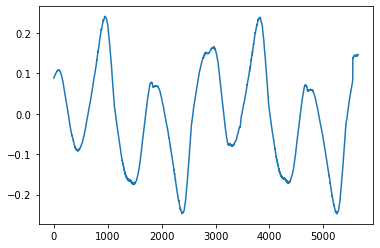

In [14]:
plt.plot(pdata['e_x'])

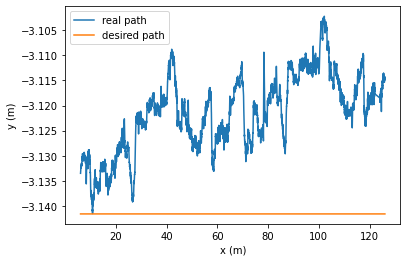

In [15]:
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
ax.plot(pdata['globaltime'],pdata['theta_r']%(2*np.pi)-np.pi,pdata['globaltime'],pdata['theta_d']%(2*np.pi)-np.pi)
ax.legend(['real path', 'desired path'])
#ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
#print(pdata.iloc[0]['x_d'])
#print(pdata.iloc[0]['y_d'])
#print(np.arctan2(y_mid[0],x_mid[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [33]:
temp=[]
for i in range(1,int(len(pdata['theta_r'])/(15*50))):
    temp = np.append(temp,pdata.iloc[i*15*50]['theta_r']%(2*np.pi)-np.pi)
    
temp[3]=temp[3]+2*np.pi
temp[4]=temp[4]+2*np.pi
temp[5]=temp[5]+2*np.pi
temp[6]=temp[6]+2*np.pi
    

[0.63537497]


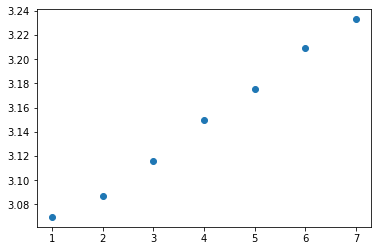

In [134]:
plt.scatter(np.linspace(1,len(temp),len(temp)),temp)
def fit_func(x, a): #Come up with linear fits for drift (b=0)
    return a*x

m = curve_fit(fit_func, np.linspace(1,len(temp),len(temp)), temp)[0]
print(m)

In [131]:
print(temp)

[ 3.06970375  3.08728215  3.11603758 -3.13335076 -3.10789924 -3.07427112
 -3.05020506]


In [38]:
pdata

,globaltime,x_r,y_r,theta_r,x_d,y_d,theta_d,e_x,e_y,e_theta,e_x_nt,e_y_nt,e_theta_nt
0,6.036275,0.322302,0.202654,-0.006382,0.243472,0.178310,0,0.078831,0.024345,-0.006382,-0.609220,0.045541,-0.006382
1,6.056239,0.319039,0.201627,-0.005714,0.239885,0.176455,0,0.079154,0.025172,-0.005714,-0.612484,0.044513,-0.005714
2,6.076418,0.315648,0.200580,-0.004473,0.236265,0.174562,0,0.079384,0.026018,-0.004473,-0.615874,0.043466,-0.004473
3,6.095970,0.312203,0.199640,-0.004030,0.232761,0.172711,0,0.079442,0.026929,-0.004030,-0.619320,0.042527,-0.004030
4,6.116637,0.308727,0.198583,-0.003538,0.229063,0.170737,0,0.079663,0.027846,-0.003538,-0.622796,0.041469,-0.003538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5642,125.897760,0.413766,0.204800,-0.034024,0.268474,0.190700,0,0.145291,0.014100,-0.034024,0.000000,0.000000,0.000000
5643,125.917783,0.410197,0.203864,-0.034486,0.264848,0.188961,0,0.145349,0.014903,-0.034486,0.000000,0.000000,0.000000
5644,125.937675,0.406500,0.202818,-0.034181,0.261249,0.187216,0,0.145251,0.015602,-0.034181,0.000000,0.000000,0.000000
5645,125.957838,0.403018,0.201942,-0.035144,0.257606,0.185429,0,0.145412,0.016513,-0.035144,0.000000,0.000000,0.000000
